In [7]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize # Usefull to access the docs

from tyssue.core.sheet import Sheet



from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.sheet_vertex_model import SheetModel as model

import tyssue.solvers.sheet_vertex_solver as solver
from tyssue.config.json_parser import load_default

from tyssue.dynamics.sheet_isotropic_model import isotropic_relax



from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.io import hdf5

multiple roots


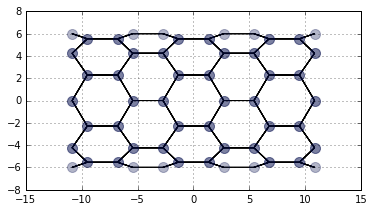

In [15]:
h5store = 'small_hexagonal.hf5'
datasets = hdf5.load_datasets(h5store, data_names=['face', 'jv', 'je'])
sheet = Sheet('emin', datasets)

sheet.set_geom('sheet')
geom.update_all(sheet)

nondim_specs = load_default('dynamics', 'sheet')
dim_model_specs = model.dimentionalize(nondim_specs)

sheet.set_model('sheet', dim_model_specs)
sheet.grad_norm_factor = sheet.specs['settings']['grad_norm_factor']
sheet.nrj_norm_factor = sheet.specs['settings']['nrj_norm_factor']

isotropic_relax(sheet, nondim_specs)

solver_settings = {
    'minimize': {
        'options': {'disp':True,
        'gtol':1e-4},
        'jac': solver.opt_grad
        }
    }



live_je = sheet.upcast_face(sheet.face_df.is_alive).astype(np.bool)
dead_je = np.logical_not(live_je)
inactive_jvs = set(sheet.je_df[dead_je].srce)

active_jvs = set(sheet.jv_df.index).difference(inactive_jvs)
active_jvs = list(active_jvs)
sheet.jv_df.is_active = 0
sheet.jv_df.loc[active_jvs, 'is_active'] = 1

fig, ax = sheet_view(sheet, ['z', 'x'])

In [20]:
je = 35

def add_jv(sheet, je):
    
    srce, trgt, face = sheet.je_df.loc[je, ['srce', 'trgt', 'face']]
    opposite = sheet.je_df[(sheet.je_df['srce'] == trgt)
                           & (sheet.je_df['trgt'] == srce)]
    opp_je = opposite.index[0]

    new_jv = sheet.jv_df.loc[[srce, trgt]].mean()
    sheet.jv_df = sheet.jv_df.append(new_jv, ignore_index=True)
    new_jv = sheet.jv_df.index[-1]
    sheet.je_df.loc[je, 'trgt'] = new_jv 
    sheet.je_df.loc[opp_je, 'srce'] = new_jv

    je_cols = sheet.je_df.loc[je]
    sheet.je_df = sheet.je_df.append(je_cols, ignore_index=True)
    new_je = sheet.je_df.index[-1]
    sheet.je_df.loc[new_je, 'srce'] = new_jv
    sheet.je_df.loc[new_je, 'trgt'] = trgt

    je_cols = sheet.je_df.loc[opp_je]
    sheet.je_df = sheet.je_df.append(je_cols, ignore_index=True)
    new_je = sheet.je_df.index[-1]
    sheet.je_df.loc[new_je, 'trgt'] = new_jv
    sheet.je_df.loc[new_je, 'srce'] = trgt
    return new_jv


In [21]:
new_jv = add_jv(sheet, 75)

97


In [22]:
sheet.reset_topo()
geom.update_all(sheet)

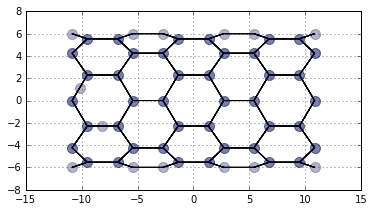

In [23]:
fig, ax = sheet_view(sheet, ['z', 'x'])

In [25]:
sheet.face_df.loc[36]

perimeter           16.239088
z                   -8.145643
x                   -4.019221
is_alive             1.000000
area                18.865118
y                   -4.019221
old_idx             36.000000
basal_shift         -3.246161
height               0.607705
vol                167.256759
vol_elasticity       1.000000
prefered_height     10.000000
contractility       96.000000
prefered_area       24.000000
num_sides            6.000000
prefered_vol       240.000000
Name: 36, dtype: float64

In [72]:
sheet.je_df.loc[face_orbit.index, sheet.ncoords]

,nx,ny,nz
172,-4.982913,-3.816093,0.696305
173,-4.691208,-4.107798,-0.000000
174,-3.816093,-4.982913,0.696305
175,-4.982913,-3.816093,-0.696305
176,-3.816093,-4.982913,-0.696305
177,-4.107798,-4.691208,0.000000


In [102]:
mother = 36

face_orbits = sheet.get_orbits('face', 'srce')

face_orbit = face_orbits.loc[mother]
n_sides = face_orbit.shape[0]
face_pos =  np.repeat(
    sheet.face_df.loc[mother, sheet.coords].values,
    n_sides).reshape(len(sheet.coords), n_sides).T

rel_pos = sheet.jv_df.loc[face_orbit.values, sheet.coords] - face_pos

normal = sheet.je_df.loc[face_orbit.index, sheet.ncoords].mean()
normal = normal / np.linalg.norm(normal)
cos_psi = normal.nx
sin_psi = normal.ny

cos_theta = normal.nz
sin_theta = (1 - cos_theta**2)**0.5

rotation = np.array([[cos_psi, -sin_psi*cos_theta,  sin_psi*sin_theta],
                     [sin_psi,  cos_psi*cos_theta, -cos_psi*sin_theta],
                     [0,        sin_theta,          cos_theta]])
rot_pos = np.dot(rotation, rel_pos.T).T

def cell_division(sheet, face):
    pass
    

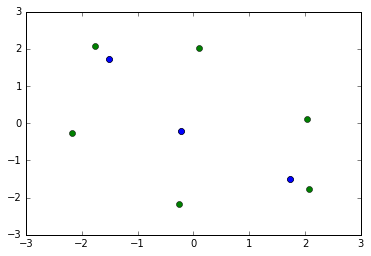

In [103]:

plt.plot(rel_pos.values[:, 0], rel_pos.values[:, 1], 'o')
plt.plot(rot_pos[:, 0], rot_pos[:, 1], 'o')


In [101]:
rotation

array([[ -7.07106781e-01,   7.07106781e-01,   8.41173087e-18],
       [ -7.07106781e-01,  -7.07106781e-01,  -8.41173087e-18],
       [  0.00000000e+00,  -1.18959839e-17,   1.00000000e+00]])

In [71]:
normal

nx   -4.399503e+00
ny   -4.399503e+00
nz   -7.401487e-17
dtype: float64

In [70]:
np.linalg.norm(normal)

6.2218366317257043

In [66]:
rel_pos

,x,y,z
60,-1.512882,1.727749,-1.357607
62,-1.512882,1.727749,1.357607
61,-0.214867,-0.214867,-2.715214
65,-0.214867,-0.214867,2.715214
74,1.727749,-1.512882,1.357607
72,1.727749,-1.512882,-1.357607


In [28]:
face_orbit

172    60
173    62
174    61
175    65
176    74
177    72
Name: srce, dtype: float64